# QEP-LVM for Regularizing the Latent Representations 

## Introduction 

In this notebook we demonstrate the QEP-LVM model class introduced in [Obite et~al, 2025](https://openreview.net/pdf?id=VOoJEQlLW5.pdf) and this [notebook](./QExponential_Process_Latent_Variable_Models_with_Stochastic_Variational_Inference.ipynb) for an introduction.

We focus on illustrating the regularizing effect of QEP-LVM by parameter $q>0$ on learning latent representations using a simulated example of [Swiss roll](https://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html) dataset. QEP-LVM tends to contract the learnt latent representation towards axes as $q$ decreases.

In [1]:
# Standard imports
import matplotlib.pylab as plt
import os
import numpy as np
from sklearn.datasets import make_swiss_roll
import torch 
from torch.utils.data import TensorDataset, DataLoader
import tqdm

%matplotlib inline

# Setting manual seed for reproducibility
seed = 2024
torch.manual_seed(seed)
np.random.seed(seed)

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

### Set up training data 

We use the canonical swiss roll data generated using `make_swiss_roll` from [scikit-learn](https://scikit-learn.org).

In [2]:
n_samples = 1000
sr_points, sr_color = make_swiss_roll(n_samples=n_samples, noise=0.05, random_state=0)
Y, t = torch.tensor(sr_points), torch.tensor(sr_color)
train_dataset = TensorDataset(Y, t, torch.arange(n_samples))
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Defining the QEPLVM model

Now we construct Bayesian QEP-LVM using `BayesianQEPLVM` in QPyTorch.
The BayesianQEPLVM is built on top of the Sparse QEP formulation. Similar to the [SVQEP example](../04_Variational_and_Approximate_QEPs/SVQEP_Regression_CUDA.ipynb), we'll use a `CholeskyVariationalDistribution` to model $q(\mathbf{u})$ and the standard `VariationalStrategy` as defined by Hensman et al. (2015).


In [3]:
# qpytorch imports
import qpytorch
from qpytorch.models.qeplvm.latent_variable import *
from qpytorch.models.qeplvm.bayesian_qeplvm import BayesianQEPLVM
from qpytorch.means import ZeroMean
from qpytorch.mlls import VariationalELBO
from qpytorch.priors import QExponentialPrior
from qpytorch.likelihoods import QExponentialLikelihood
from qpytorch.variational import VariationalStrategy
from qpytorch.variational import CholeskyVariationalDistribution
from qpytorch.kernels import ScaleKernel, RBFKernel
from qpytorch.distributions import MultivariateQExponential


def _pca(Y, latent_dim):
    U, S, V = torch.pca_lowrank(Y, q = latent_dim)
    return torch.matmul(Y, V[:,:latent_dim])

class bQEPLVM(BayesianQEPLVM):
    def __init__(self, power, n, data_dim, latent_dim, n_inducing, pca=False):
        self.power = torch.tensor(power)
        self.n = n
        self.batch_shape = torch.Size([data_dim])

        # Locations Z_{d} corresponding to u_{d}, they can be randomly initialized or
        # regularly placed with shape (D x n_inducing x latent_dim).
        self.inducing_inputs = torch.randn(data_dim, n_inducing, latent_dim)

        # Sparse Variational Formulation (inducing variables initialised as randn)
        q_u = CholeskyVariationalDistribution(n_inducing, batch_shape=self.batch_shape, power=self.power)
        q_f = VariationalStrategy(self, self.inducing_inputs, q_u, learn_inducing_locations=True)

        # Define prior for X
        X_prior_mean = torch.zeros(n, latent_dim)  # shape: N x Q
        prior_x = QExponentialPrior(X_prior_mean, torch.ones_like(X_prior_mean), power=self.power)

        # Initialise X with PCA or randn
        if pca == True:
             X_init = torch.nn.Parameter(_pca(Y.float(), latent_dim)) # Initialise X to PCA
        else:
             X_init = torch.nn.Parameter(torch.randn(n, latent_dim))

        # LatentVariable (c)
        X = VariationalLatentVariable(n, data_dim, latent_dim, X_init, prior_x)

        # For (a) or (b) change to below:
        # X = PointLatentVariable(n, latent_dim, X_init)
        # X = MAPLatentVariable(n, latent_dim, X_init, prior_x)

        super().__init__(X, q_f)

        # Kernel (acting on latent dimensions)
        self.mean_module = ZeroMean(ard_num_dims=latent_dim)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=latent_dim))

    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateQExponential(mean_x, covar_x, power=self.power)
        return dist

    def _get_batch_idx(self, batch_size, seed=None):
        valid_indices = np.arange(self.n)
        batch_indices = np.random.choice(valid_indices, size=batch_size, replace=False) if seed is None else \
                        np.random.default_rng(seed).choice(valid_indices, size=batch_size, replace=False)
        return np.sort(batch_indices)

## Training the model

While we need to specify the dimensionality of the latent variables at the outset, one of the advantages of the Bayesian framework is that by using a ARD kernel we can prune dimensions corresponding to small inverse lengthscales.
We train multiple QEP-LVM models with different $q$s to illustrate the regularization effect.

In [4]:
N = len(Y)
data_dim = Y.shape[1]
latent_dim = data_dim
n_inducing = 25
pca = False


We use mini-batch training for scalability where only a subset of the local variaitonal params are optimised in each iteration. 

In [5]:
# Training loop - optimises the objective wrt kernel hypers, variational params and inducing inputs
# using the optimizer provided.
num_epochs = 1000 if not smoke_test else 4

model_list = []
for q in [1.0, 1.5, 2.0]:
    # Model
    model = bQEPLVM(q, N, data_dim, latent_dim, n_inducing, pca=pca)
    
    # Likelihood
    likelihood = QExponentialLikelihood(batch_shape=model.batch_shape, power=model.power)
    
    # Declaring the objective to be optimised along with optimiser 
    # (see models/latent_variable.py for how the additional loss terms are accounted for)
    mll = VariationalELBO(likelihood, model, num_data=len(Y))
        
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()}
    ], lr=0.01)
    
    # train model
    iterator = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for epoch in iterator: 
        batch_index = model._get_batch_idx(batch_size)
        optimizer.zero_grad()
        sample = model.sample_latent_variable()  # a full sample returns latent x across all N
        sample_batch = sample[batch_index]
        output_batch = model(sample_batch)
        loss = -mll(output_batch, Y[batch_index].T).sum()
        iterator.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

    # save
    model_list.append(model)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

## Visualising the 2d latent subspace
Visualising a two dimensional slice of the latent space corresponding to the most dominant latent dimensions.  

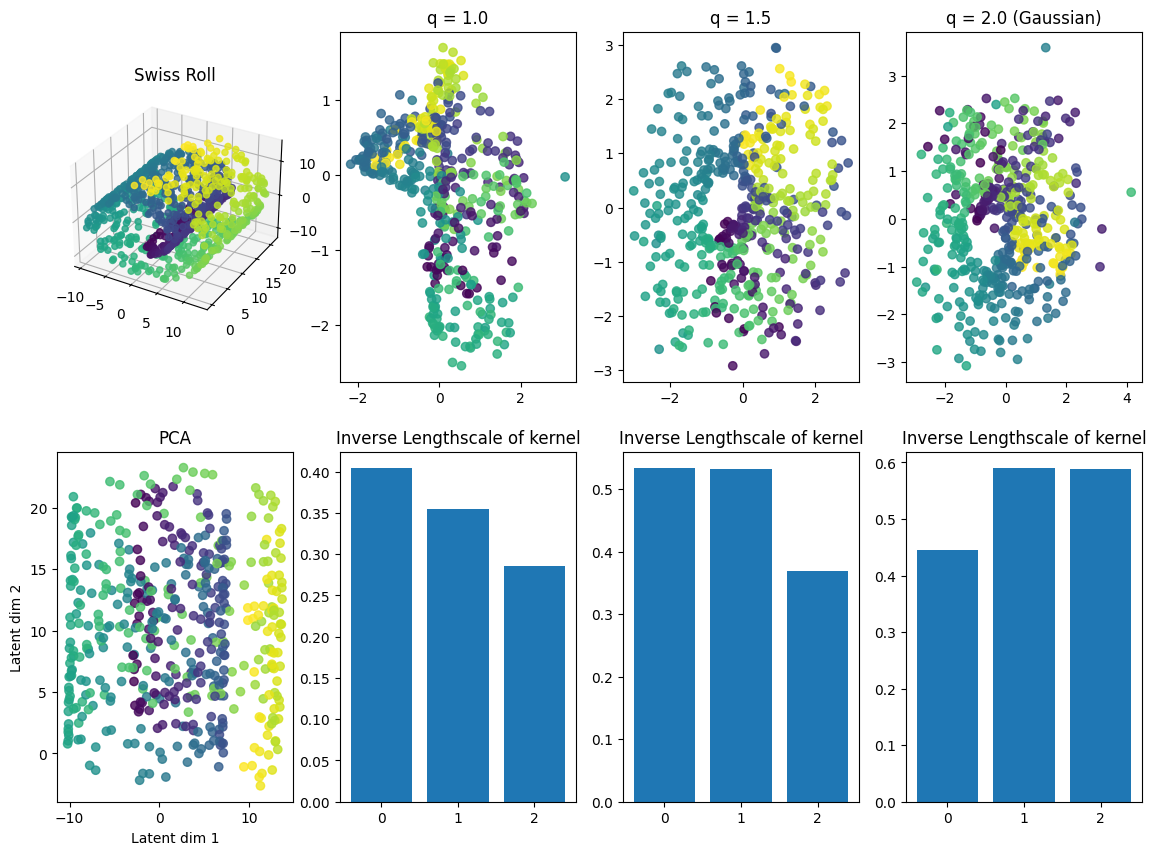

In [6]:
# Initialize plots
fig, ax = plt.subplots(2, 4, figsize=(14, 10))
idx2plot = np.random.default_rng(seed).choice(n_samples, size=500, replace=False)
colors = t[idx2plot]

# visualize 3d dataset
ax[0,0].remove()
ax[0,0]=fig.add_subplot(241, projection="3d")
ax[0,0].scatter(sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, alpha=0.8)
ax[0,0].set_title('Swiss Roll')

# PCA
X = _pca(Y, 2)[idx2plot]
ax[1,0].scatter(X[:, 0], X[:,1], c=colors, alpha=0.8)
ax[1,0].set_title('PCA')
ax[1,0].set_xlabel('Latent dim 1')
ax[1,0].set_ylabel('Latent dim 2')

# QEP-LVM
for i, q in enumerate([1.0, 1.5, 2.0]):
    # obtain model
    model = model_list[i]
    model.eval()
    
    inv_lengthscale = 1 / model.covar_module.base_kernel.lengthscale
    values, indices = torch.topk(model.covar_module.base_kernel.lengthscale, k=2,largest=False)
    l1, l2 = indices.detach().numpy().flatten()[:2]

    idx2plot = model._get_batch_idx(500, seed)
    X = (model.X.q_mu if hasattr(model.X, 'q_mu') else model.X.X).detach().numpy()[idx2plot]
    colors = t[idx2plot]
    
    # Select index of the smallest lengthscales by examining model.covar_module.base_kernel.lengthscales 
    ax[0, i+1].scatter(X[:, l1], X[:, l2], c=colors, alpha=0.8)
    ax[0, i+1].set_title('q = '+str(q)+(' (Gaussian)' if q==2 else ''))
    
    ax[1, i+1].bar(np.arange(latent_dim), height=inv_lengthscale.detach().numpy().flatten())
    ax[1, i+1].set_title('Inverse Lengthscale of kernel')

None

The latent space learned by QEP-LVM tends to contract towards axes as $q$ decreases. Therefore, the resulting latent representation becomes more compact with smaller $q$.